In [12]:
import pandas as pd
data = pd.read_csv('../data_train/stringtie_tss_labeled.csv')
print("StringTie TSS",data['label'].value_counts())
print("StringTie TSS",data['label'].value_counts(normalize=True))
print(data['chrom'].value_counts())
data_true = data[data['label'] == 1].sample(frac=1).head(5)
print("True TSS")
print(data_true[['chrom', 'position', 'delta_coverage' , 'read_start_density']])
data_false = data[data['label'] == 0].sample(frac=1).head(5)
print("False TSS")
print(data_false[['chrom', 'position', 'delta_coverage' , 'read_start_density']])
pdata = data[data['chrom'] == 'chr15']
print(pdata[['chrom', 'position', 'label']].iloc[:26])

data = pd.read_csv('../data_train/stringtie_tes_labeled.csv')
print("StringTie TES",data['label'].value_counts())
print("StringTie TES",data['label'].value_counts(normalize=True))
print(data['chrom'].value_counts())
data = pd.read_csv('../data_train/isoquant_tss_labeled.csv')
print("IsoQuant TSS",data['label'].value_counts())
print("IsoQuant TSS",data['label'].value_counts(normalize=True))
data = pd.read_csv('../data_train/isoquant_tes_labeled.csv')
print("IsoQuant TES",data['label'].value_counts())
print("IsoQuant TES",data['label'].value_counts(normalize=True))


# print minimum 5 and maximum 5 delta coverage rows

# print(data.loc[data['delta_coverage'].idxmax(), ['chrom', 'position', 'delta_coverage']])
# print(data.loc[data['delta_coverage'].idxmin(), ['chrom', 'position', 'delta_coverage']])

# # print five chromosomes and positions with label 1
# print(data.loc[data['label'] == 1, ['chrom', 'position', 'delta_coverage']].sample(frac=1).head(5))
# print(data.columns)

StringTie TSS label
0    6851
1    5639
Name: count, dtype: int64
StringTie TSS label
0    0.548519
1    0.451481
Name: proportion, dtype: float64
chrom
chr1          1248
chr2           853
chr19          829
chr17          779
chr3           711
chr12          701
chr11          693
chr6           632
chr7           626
chr5           585
chr16          582
chr9           510
chr14          446
chr4           446
chr10          445
chr15          412
chr8           408
chrX           373
chr22          338
chr20          306
chr13          247
chr18          164
chr21          131
chrY            10
GL000195.1       4
GL000205.2       4
KI270742.1       2
GL000218.1       1
KI270721.1       1
GL000219.1       1
GL000224.1       1
GL000194.1       1
Name: count, dtype: int64
True TSS
      chrom  position  delta_coverage  read_start_density
6226  chr19  38619186           20947                 333
3160  chr13  32586455             197                   3
292    chr1  32650591         

In [5]:
import os
import pandas as pd
from glob import glob

data_name = ""

def generate_summary(data_name, anno):
    print(f"Generating summary for {data_name} with annotation {anno}...")
    # Paths
    REPORTS_DIR = f"../out/{data_name}/{anno}/reports"
    OUTPUT_MD = os.path.join(REPORTS_DIR, f"{data_name}_{anno}_metrics_summary.md")

    # Model variants we expect in filenames
    MODELS = ["xgboost", "randomforest"]
    SITE_TYPES = ["tss", "tes"]
    TOOLS = ["stringtie", "isoquant", "universe"] if not "SRR" in data_name else ["stringtie", "scallop2", "universe"]

    results = []

    # Search for all metrics summary files
    for site_type in SITE_TYPES:
        for tool in TOOLS:
            for model in MODELS:
                path = os.path.join(REPORTS_DIR, site_type, f"{tool}_{model}_metrics_summary.txt")
                if not os.path.exists(path):
                    print(f"⚠️ No metrics file found for {tool} {model} on {site_type}. Skipping.")
                    continue

                metrics = {
                    "Tool": tool,
                    "Site Type": site_type,
                    "Model": model
                }
                with open(path) as f:
                    lines = f.readlines()

                    # Track confusion matrix separately
                    confusion = {}

                    for i, line in enumerate(lines):
                        line = line.strip()
                        if not line:
                            continue
                        if line.startswith("confusion_matrix"):
                            for j in range(1, 5):
                                if i + j < len(lines):
                                    subline = lines[i + j].strip()
                                    if ":" in subline:
                                        subkey, subval = subline.split(":", 1)
                                        confusion[subkey.strip()] = int(subval.strip())
                            continue
                        if ":" in line:
                            key, value = line.split(":", 1)
                            key = key.strip().lower()
                            try:
                                metrics[key] = float(value.strip())
                            except ValueError:
                                continue
                    
                    metrics.update({
                        "TP": confusion.get("TP", 0),
                        "FP": confusion.get("FP", 0),
                        "FN": confusion.get("FN", 0),
                        "TN": confusion.get("TN", 0)
                    })
                    # Class 1 (positive)
                    tp = metrics["TP"]
                    fp = metrics["FP"]
                    fn = metrics["FN"]
                    tn = metrics["TN"]

                    prec_1 = tp / max(tp + fp, 1)
                    rec_1  = tp / max(tp + fn, 1)
                    f1_1   = 2 * prec_1 * rec_1 / max(prec_1 + rec_1, 1)

                    # Class 0 (negative)
                    prec_0 = tn / max(tn + fn, 1)
                    rec_0  = tn / max(tn + fp, 1)
                    f1_0   = 2 * prec_0 * rec_0 / max(prec_0 + rec_0, 1)

                    metrics.update({
                        "precision_class_1": prec_1,
                        "recall_class_1": rec_1,
                        "f1_class_1": f1_1,
                        "precision_class_0": prec_0,
                        "recall_class_0": rec_0,
                        "f1_class_0": f1_0,
                    })

                    # Add class-wise results
                    
                results.append(metrics)

    # Create markdown report
    if results:
        df = pd.DataFrame(results)
        df = df[[
            "Tool", "Site Type", "Model",
            "accuracy", "precision", "recall", "f1", "aupr", "auc",
            "TP", "FP", "FN", "TN",
            "precision_class_1", "recall_class_1", "f1_class_1",
            "precision_class_0", "recall_class_0", "f1_class_0"
        ]]

        os.makedirs(REPORTS_DIR, exist_ok=True)
        # with open(OUTPUT_MD, "w") as f:
        #     f.write("# Combined Model Evaluation Summary\n\n")
        #     f.write(df.to_csv(index=False))
        df.to_csv(OUTPUT_MD, index=False)
        print(f"✅ Markdown summary written to {OUTPUT_MD}")
    else:
        print("⚠️ No metrics files found. Nothing to summarize.")

data_name = ["nanopore_cDNA_NA12878", "nanopore_dRNA_NA12878", "pacbio_ENCFF450VAU", "pacbio_ENCFF694DIE", 
             "SRR307903_hisat", "SRR307911_hisat", "cv_Hek293T_dRNA", "cv_K562_cDNA", "cv_pacbio_ENCFF694DIE", "cv_SRR307911_hisat"]

for name in data_name:
    # check if data_name contains "SRR"
    if "SRR" in name:
        generate_summary(name, "ensembl")
    elif "cv" in name:
        generate_summary(name, "gencode")
    else:
        generate_summary(name, "gencode")
        generate_summary(name, "refSeq")

Generating summary for nanopore_cDNA_NA12878 with annotation gencode...
✅ Markdown summary written to ../out/nanopore_cDNA_NA12878/gencode/reports/nanopore_cDNA_NA12878_gencode_metrics_summary.md
Generating summary for nanopore_cDNA_NA12878 with annotation refSeq...
✅ Markdown summary written to ../out/nanopore_cDNA_NA12878/refSeq/reports/nanopore_cDNA_NA12878_refSeq_metrics_summary.md
Generating summary for nanopore_dRNA_NA12878 with annotation gencode...
✅ Markdown summary written to ../out/nanopore_dRNA_NA12878/gencode/reports/nanopore_dRNA_NA12878_gencode_metrics_summary.md
Generating summary for nanopore_dRNA_NA12878 with annotation refSeq...
✅ Markdown summary written to ../out/nanopore_dRNA_NA12878/refSeq/reports/nanopore_dRNA_NA12878_refSeq_metrics_summary.md
Generating summary for pacbio_ENCFF450VAU with annotation gencode...
✅ Markdown summary written to ../out/pacbio_ENCFF450VAU/gencode/reports/pacbio_ENCFF450VAU_gencode_metrics_summary.md
Generating summary for pacbio_ENCFF

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Get PR curve data CSVs
tss_files = glob.glob("../out/plots/tss/*_pr_data.csv")
tes_files = glob.glob("../out/plots/tes/*_pr_data.csv")

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot TSS
for file in tss_files:
    df = pd.read_csv(file)
    label = file.split("/")[-1].replace("_pr_curve_pr_data.csv", "").replace("_", " (").title()
    axs[0].plot(df["recall"], df["precision"], label=f"{label})")
axs[0].set_title("TSS PR Curves")
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].legend()

# Plot TES
for file in tes_files:
    df = pd.read_csv(file)
    label = file.split("/")[-1].replace("_pr_curve_pr_data.csv", "").replace("_", " (").title()
    axs[1].plot(df["recall"], df["precision"], label=f"{label})")
axs[1].set_title("TES PR Curves")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend()

# Save and show
plt.tight_layout()
plt.savefig("../out/plots/pr_curves_tss_tes_subplots.png")
plt.show()


In [14]:
data = pd.read_csv('../data_train/stringtie_tss_labeled.csv')
all_chromosomes = data['chrom'].unique()
train_chromomes = ['chr'+str(i) for i in range(1, 15)]
validation_chromosomes = [chrom for chrom in all_chromosomes if chrom not in train_chromomes]
# write validation chromosomes in a file - as a list
with open('../data_train/validation_chromosomes.txt', 'w') as f:
    for chrom in validation_chromosomes:
        f.write(f"{chrom}\n")



In [ ]:
pred_data = pd.read_csv('../out/predictions/stringtie_xgboost_merged.tsv', sep='\t')
pred_data = pred_data[['chrom', 'position', 'prediction']]
print(pred_data['chrom'].value_counts())
pred_data[pred_data['chrom'] == 'chrY']

In [ ]:
import pandas as pd

# your existing pivot function
def make_pivot_table(metrics_csv: str) -> pd.DataFrame:
    df = pd.read_csv(metrics_csv)
    clf = df[df['Model'].isin(['xgboost','randomforest'])]
    pivot = clf.pivot_table(
        index=['Tool','Site Type'],
        columns='Model',
        values=['recall','precision','f1'],
        aggfunc='first'
    )
    pivot.columns = [f"{model}_{metric}" for metric, model in pivot.columns]
    return pivot.reset_index()

# helper to compute baseline fractions
def compute_baseline_metrics(data_name: str,
                             annotation: str,
                             tool: str,
                             site_type: str) -> pd.Series:
    """
    Reads {data_name}/{annotation}/{tool}_{site_type}_labeled.csv,
    filters validation chromosomes (chr6+), and returns
    normalized counts of label==1 and label==0.
    """
    path = f"../data_train/{data_name}/{annotation}/{tool}_{site_type}_labeled.csv"
    lab = pd.read_csv(path)
    # validation = anything not in chr1–chr5
    val = lab[~lab['chrom'].isin([f"chr{i}" for i in range(1,6)])]
    vc = val['label'].value_counts(normalize=True)
    return pd.Series({
        'baseline_precision': vc.get(1, 0.0),
        'baseline_recall': 1,
        'baseline_f1': 2 * vc.get(1, 0.0) / (vc.get(1, 0.0) + 1),
        'baseline_npredictions': len(val)
    })

# list of your datasets
data_names = [
    "nanopore_cDNA_NA12878", "nanopore_dRNA_NA12878",
    "pacbio_ENCFF450VAU", "pacbio_ENCFF694DIE",
    "SRR307903_hisat", "SRR307911_hisat",
    "cv_Hek293T_dRNA", "cv_K562_cDNA",
    "cv_pacbio_ENCFF694DIE", "cv_SRR307911_hisat"
]

frames = []
for name in data_names:
    # decide which annotations to process for this dataset
    to_process = []
    if "SRR" in name:
        to_process.append(("ensembl", f"../out/demo/{name}_ensembl_metrics_summary.csv"))
    elif name.startswith("cv"):
        to_process.append(("gencode", f"../out/demo/{name}_gencode_metrics_summary.csv"))
    else:
        to_process.append(("gencode", f"../out/demo/{name}_gencode_metrics_summary.csv"))
        to_process.append(("refSeq",  f"../out/demo/{name}_refSeq_metrics_summary.csv"))

    for annotation, metrics_path in to_process:
        # 1) pivot your classifiers
        tbl = make_pivot_table(metrics_path)

        # 2) compute and append baseline metrics row‐wise
        baselines = tbl.apply(
            lambda row: compute_baseline_metrics(
                data_name=name,
                annotation=annotation,
                tool=row['Tool'],
                site_type=row['Site Type']
            ),
            axis=1
        )
        tbl = pd.concat([tbl, baselines], axis=1)

        # 3) insert Dataset & Annotation columns
        tbl.insert(0, 'Annotation', annotation)
        tbl.insert(0, 'Dataset',    name)

        frames.append(tbl)

# 4) concatenate and write out
final_table = pd.concat(frames, ignore_index=True)
final_table.to_excel('../out/demo/summary_table_stage1_with_baseline.xlsx', index=False)
print("Wrote:", final_table.shape, "rows to summary_table_stage1_with_baseline.xlsx")


Wrote: (84, 14) rows to summary_table_stage1_with_baseline.xlsx


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
os.chdir("/datadisk1/ixk5174/tools/tss-tes-project")
# —— USER SETTINGS ——
data_names = [
    "nanopore_cDNA_NA12878/gencode",
    "nanopore_dRNA_NA12878/gencode",
    "pacbio_ENCFF450VAU/gencode",
    "SRR307903_hisat/ensembl"
]

name_dict = {
    "nanopore_cDNA_NA12878/gencode": "cDNA NA12878",
    "nanopore_dRNA_NA12878/gencode": "dRNA NA12878",
    "pacbio_ENCFF450VAU/gencode": "ENCFF450VAU",
    "SRR307903_hisat/ensembl": "SRR307903"
}
site_types = ["tss", "tes"]
# ———————

# create a 4×2 grid: 4 datasets × 2 site-types
fig, axes = plt.subplots(
    nrows=len(data_names),
    ncols=len(site_types),
    figsize=(12, 3 * len(data_names)),
    sharex=False,
    sharey=False
)

for i, name in enumerate(data_names):
    for j, site in enumerate(site_types):
        ax = axes[i, j]
        pr_dir = os.path.join("out", name, "plots", site)
        # plot each tool_model PR curve + its baseline point
        for fname in sorted(os.listdir(pr_dir)):
            if not fname.endswith("_pr_curve_pr_data.csv"):
                continue

            tool_model = fname.replace("_pr_curve_pr_data.csv", "")
            if "universe" in tool_model:
                continue
            pr_df = pd.read_csv(os.path.join(pr_dir, fname))

            # full PR curve
            ax.plot(
                pr_df["recall"],
                pr_df["precision"],
                label=tool_model.replace("_", " ").title() 
            )

            # baseline: recall=1, precision = fraction of label==1
            pred_path = os.path.join(
                "out", name, "predictions", site,
                f"{tool_model}_predictions.tsv"
            )
            pred_df = pd.read_csv(pred_path, sep="\t")
            baseline_prec = pred_df["label"].mean()
            ax.scatter(
                1.0,
                baseline_prec,
                marker="o",
                s=40,
                edgecolor="k",
                zorder=10
            )

        # formatting per‐subplot
        ax.set_title(f"{name_dict[name]} - {site.upper()}", fontsize=12)
        if i == len(data_names) - 1:
            ax.set_xlabel("Recall", fontsize=10)
        if j == 0:
            ax.set_ylabel("Precision", fontsize=10)
        # ax.tick_params(labelsize= nine)  # increase tick labels if you wish
        ax.legend(fontsize=8, loc="lower left")

plt.tight_layout()
os.makedirs("out/plots", exist_ok=True)
plt.savefig("out/plots/all_pr_curves_grid.png", dpi=300)
plt.close(fig)
print("Saved: out/plots/all_pr_curves_grid.png")


Saved: out/plots/all_pr_curves_grid.png


In [18]:
import pandas as pd
import glob
import os

def load_and_tag(path: str):
    # print(path)
    # parse dataset & annotation from path
    parts = path.split(os.sep)
    # e.g. out/{data}/{anno}/predictions/transcripts/metrics_summary_tr_model.csv
    dataset, annotation = parts[1], parts[2]
    df = pd.read_csv(path)
    # keep only the two models & your three tools
    df = df[df['model'].isin(['xgboost','randomforest']) &
            df['tool'].isin(['stringtie','isoquant','scallop2'])]
    # tag
    df['Dataset']    = dataset
    df['Annotation'] = annotation
    print(f"Loaded dataset: {dataset}, annotation: {annotation}")
    # print(df)
    return df

def make_multiindex_df(all_df: pd.DataFrame):
    metrics = [c for c in all_df.columns
               if c not in ('Dataset','Annotation','tool','model')]
    # pivot: index = Dataset,Annotation,tool; columns = model; values = metrics
    pivot = all_df.pivot_table(
        index=['Dataset','Annotation','tool'],
        columns='model',
        values=metrics,
        aggfunc='first'
    )
    # swap levels so first-level= model, second-level=metric
    pivot = pivot.swaplevel(0,1,axis=1).sort_index(axis=1, level=0)
    # print(pivot.to_markdown(index=False))
    return pivot

def main():
    os.chdir('/datadisk1/ixk5174/tools/tss-tes-project')
    pattern = os.path.join('out','*','*','predictions',
                           'metrics_summary_tr_model.csv')
    dfs = [ load_and_tag(p) for p in glob.glob(pattern) ]
    all_df = pd.concat(dfs, ignore_index=True)

    multi = make_multiindex_df(all_df)

    # 1) Flatten
    flat = multi.copy()
    flat.columns = [f"{model}_{metric}" for model, metric in flat.columns]

    # 2) Bring the index into columns
    flat = flat.reset_index()   # now you have Dataset, Annotation, tool as real columns

    # 3) Reorder so that all xgboost_* columns come together, then all randomforest_* 
    id_cols   = ['Dataset','Annotation','tool']
    xgb_cols  = [c for c in flat.columns if c.startswith('xgboost_')]
    rf_cols   = [c for c in flat.columns if c.startswith('randomforest_')]

    flat = flat[id_cols + xgb_cols + rf_cols]

    # Now you can save as CSV/JSON/Markdown
    flat.to_csv('out/demo/all_transcript_metrics_flat.csv', index=False)
    # with open('all_transcript_metrics.md','w') as f:
    #     f.write(flat.to_markdown(index=False))

    # 1) Save as Markdown (will preserve MultiIndex header)
    # with open('out/demo/all_transcript_metrics.md','w') as f:
    #     f.write(multi.to_markdown())

    # 2) Save as JSON (table orientation preserves indices & column labels)
    # multi.reset_index().to_json(
    #     'out/demo/all_transcript_metrics.json',
    #     orient='table',
    #     indent=2
    # )


    print("Wrote markdown & json with multi‐level headers")

if __name__ == '__main__':
    main()


Loaded dataset: SRR307903_hisat, annotation: ensembl
Loaded dataset: cv_K562_cDNA, annotation: gencode
Loaded dataset: nanopore_cDNA_NA12878, annotation: refSeq
Loaded dataset: nanopore_cDNA_NA12878, annotation: gencode
Loaded dataset: pacbio_ENCFF694DIE, annotation: refSeq
Loaded dataset: pacbio_ENCFF694DIE, annotation: gencode
Loaded dataset: pacbio_ENCFF450VAU, annotation: refSeq
Loaded dataset: pacbio_ENCFF450VAU, annotation: gencode
Loaded dataset: cv_Hek293T_dRNA, annotation: gencode
Loaded dataset: cv_SRR307911_hisat, annotation: ensembl
Loaded dataset: nanopore_dRNA_NA12878, annotation: refSeq
Loaded dataset: nanopore_dRNA_NA12878, annotation: gencode
Loaded dataset: cv_pacbio_ENCFF694DIE, annotation: gencode
Loaded dataset: SRR307911_hisat, annotation: ensembl
Wrote markdown & json with multi‐level headers


['/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/isoquant-xgboost-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/isoquant-baseline-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/stringtie-baseline-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/stringtie-universe-xgboost-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/isoquant-randomforest-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/isoquant-universe-randomforest-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc/stringtie-xgboost-updated-cov.roc', '/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacb

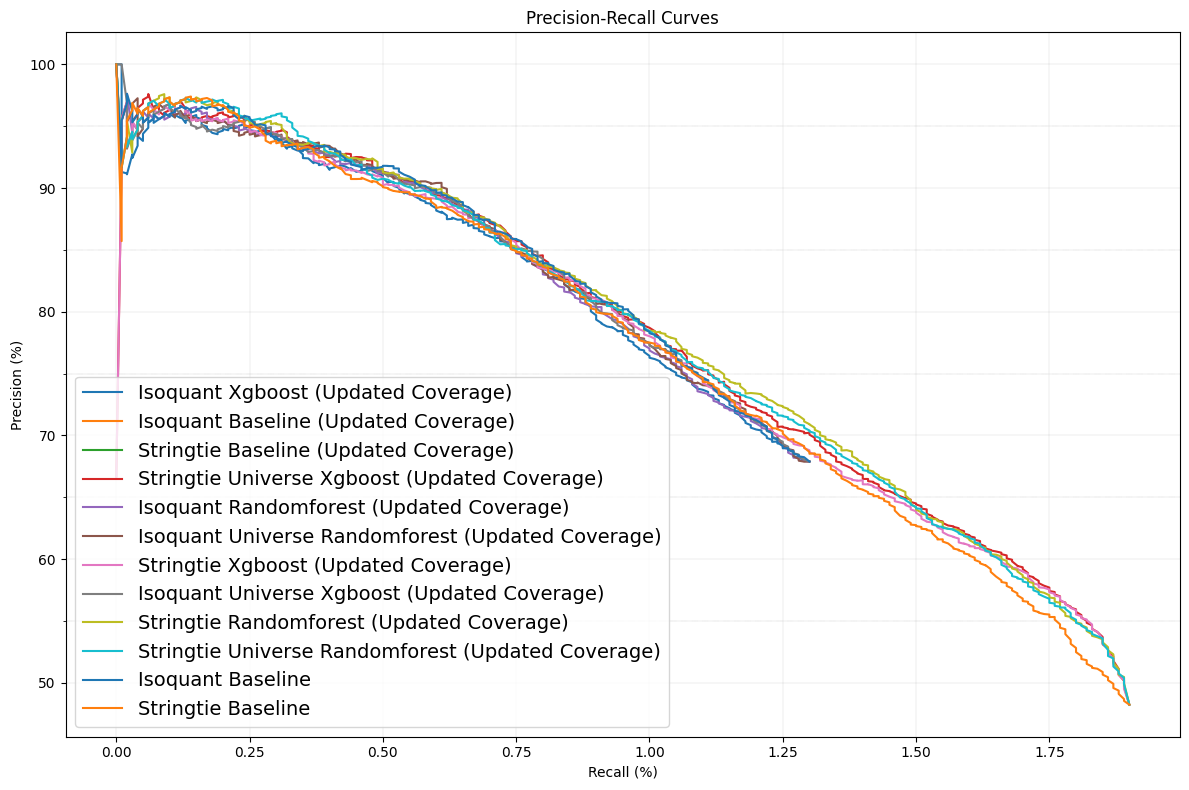

In [4]:
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_pr_curves(folder_path):
    """
    Reads all ROC-like files in the specified folder, parses sensitivity (recall)
    and precision values, and plots Precision-Recall curves for each file.
    """
    plt.figure(figsize=(12, 8))

    # Enable minor ticks and set their spacing
    plt.minorticks_on()
    plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(1))  # 4 minor intervals per major
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

    
    # Find all files in the folder
    file_paths = glob.glob(os.path.join(folder_path, '*'))
    print(file_paths)
    
    for file_path in file_paths:
        recalls = []
        precisions = []
        
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('ROC:'):
                    # Extract sensitivity and precision values
                    rec_match = re.search(r'sensitivity\s*=\s*([0-9.]+)', line)
                    prec_match = re.search(r'precision\s*=\s*([0-9.]+)', line)
                    if rec_match and prec_match:
                        recalls.append(float(rec_match.group(1)))
                        precisions.append(float(prec_match.group(1)))
        
        # Plot the curve for this file
        label = os.path.basename(file_path)
        label = label.replace('-', ' ').replace('.roc', '').title()
        label = label.replace('Updated Cov', '(Updated Coverage)')
        # if "Isoquant" in label or "Isoquant Baseline" in label:
            # plt.plot(recalls, precisions, label=label)
        plt.plot(recalls, precisions, label=label)
    
    # Draw major & minor grid
    plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
    plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.3)

    plt.xlabel('Recall (%)')
    plt.ylabel('Precision (%)')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left', fontsize=14)
    plt.grid(True, linewidth=0.1)   
    plt.tight_layout()
    plt.savefig('../out/plots/pacbio_ENCFF694DIE_pr_curves_compare.png')
    # plt.show()

# Replace with the path to your folder containing the ROC files
plot_pr_curves('/datadisk1/ixk5174/long_reads_compare/out/gffcomp-results/pacbio_ENCFF694DIE/updated-cov/roc')


In [ ]:
import os 

output_dir = "../out/"
os.makedirs(f"{output_dir}/demo/", exist_ok=True)
dirs = os.listdir(output_dir)
ld = []
for d in dirs:
    if d.startswith("nanopore") or d.startswith("pacbio") or d.startswith("SRR") or d.startswith("cv"):
        ld.append(d) 

anno_long = ["gencode", "refSeq"] 
anno_short = ["ensembl"]
for d in ld:
    anno = anno_short if "SRR" in d else anno_long
    for a in anno:
        os.makedirs(f"{output_dir}/demo/{d}_{a}", exist_ok=True)
        pld = os.path.join(output_dir, f"{d}/{a}/plots/")
        # copy files from pld to demo
        if not os.path.exists(pld):
            print(f"Path does not exist: {pld}")
            continue
        os.system(f"cp {pld}*pdf ../out/demo/{d}_{a}/")




Path does not exist: ../out/cv_K562_cDNA/refSeq/plots/
Path does not exist: ../out/cv_Hek293T_dRNA/refSeq/plots/
Path does not exist: ../out/cv_pacbio_ENCFF694DIE/refSeq/plots/


In [7]:
import os 

output_dir = "../out/"
os.makedirs(f"{output_dir}/demo/", exist_ok=True)
dirs = os.listdir(output_dir)
ld = []
for d in dirs:
    if d.startswith("nanopore") or d.startswith("pacbio") or d.startswith("SRR") or d.startswith("cv"):
        ld.append(d)

anno_long = ["gencode", "refSeq"]
anno_short = ["ensembl"]

for d in ld:
    anno = anno_short if "SRR" in d else anno_long
    for a in anno:
        os.makedirs(f"{output_dir}/demo/{d}_{a}", exist_ok=True)
        pld = os.path.join(output_dir, f"{d}/{a}/reports/")

        # copy files from pld to demo
        os.system(f"cp {pld}*metrics_summary.md ../out/demo/{d}_{a}_metrics_summary.csv")




cp: cannot stat '../out/cv_K562_cDNA/refSeq/reports/*metrics_summary.md': No such file or directory
cp: cannot stat '../out/cv_Hek293T_dRNA/refSeq/reports/*metrics_summary.md': No such file or directory
cp: cannot stat '../out/cv_pacbio_ENCFF694DIE/refSeq/reports/*metrics_summary.md': No such file or directory


In [ ]:
mapping = pd.read_csv('../data/GRCh38_RefSeq2UCSC.txt', sep='\t')
mapping = mapping[['RefSeq', 'UCSC']]
mapping = mapping.rename(columns={'RefSeq': 'refseq', 'UCSC': 'ucsc'})

ref = pd.read_csv('../data/GRCh38_refSeq.gtf', sep='\t', comment='#', header=None)
ref.columns = ['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
